# Field Encoders


In [1]:
import torch
import mediapy as media
from nerfactory.fields.modules import encoding

## NeRF Positional Encoding
First introduced in the original NeRF paper. This encoding assumes the inputs are between zero and one and can opperate on any dimensional input.

Input Values:


,

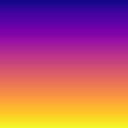
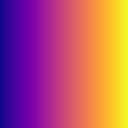

Encoded Values:


,,,,,,,,,,,,,,,

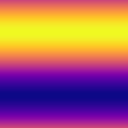
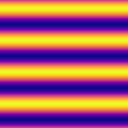
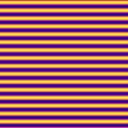
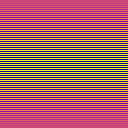
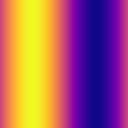
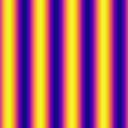
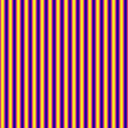
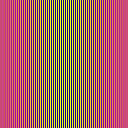
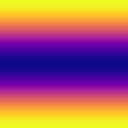
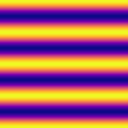
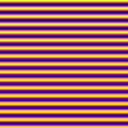
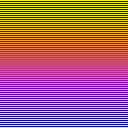
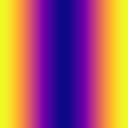
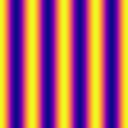
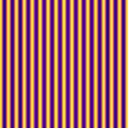
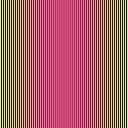

Encoded Integrate Values:
Covariance Magnitude: 0.01


,,,,,,,,,,,,,,,

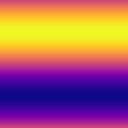
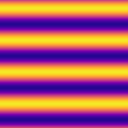
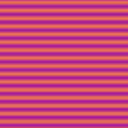
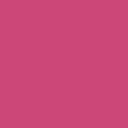
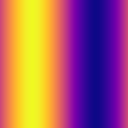
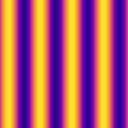
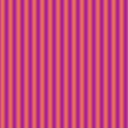
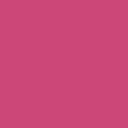
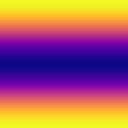
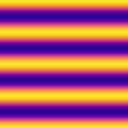
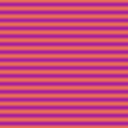
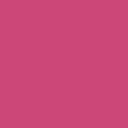
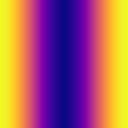
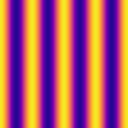
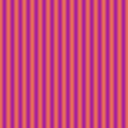
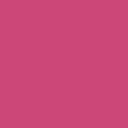

Covariance Magnitude: 0.1


,,,,,,,,,,,,,,,

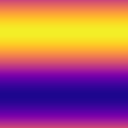
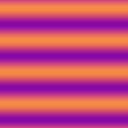
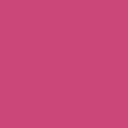
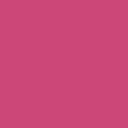
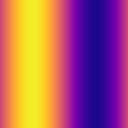
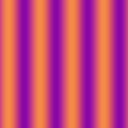
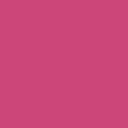
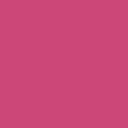
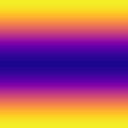
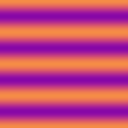
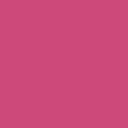
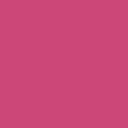
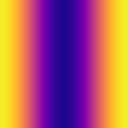
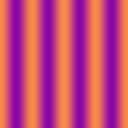
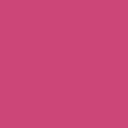
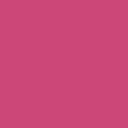

Covariance Magnitude: 1


,,,,,,,,,,,,,,,

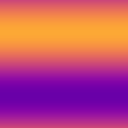
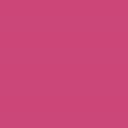
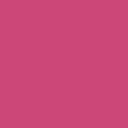
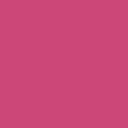
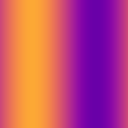
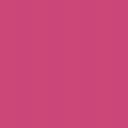
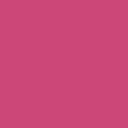
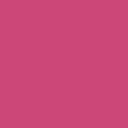
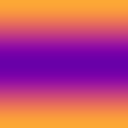
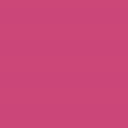
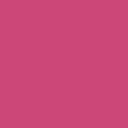
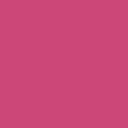
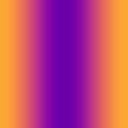
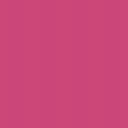
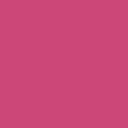
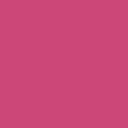

In [5]:
num_frequencies = 4
min_freq_exp = 0
max_freq_exp = 6
include_input = False
resolution = 128
covariance_magnitudes = [0.01, 0.1, 1]

encoder = encoding.NeRFEncoding(
    in_dim=2,
    num_frequencies=num_frequencies,
    min_freq_exp=min_freq_exp,
    max_freq_exp=max_freq_exp,
    include_input=include_input,
)

x_samples = torch.linspace(0, 1, resolution)
grid = torch.stack(torch.meshgrid([x_samples, x_samples], indexing="ij"), dim=-1)

encoded_values = encoder(grid)

print("Input Values:")
media.show_images(torch.moveaxis(grid, 2, 0), cmap="plasma", border=True)
print("Encoded Values:")
media.show_images(torch.moveaxis(encoded_values, 2, 0), vmin=-1, vmax=1, cmap="plasma", border=True)

print("Encoded Integrate Values:")
for covariance_magnitude in covariance_magnitudes:
    print(f"Covariance Magnitude: {covariance_magnitude}")
    covs = torch.eye(2)[None, None, :, :] * covariance_magnitude
    encoded_values = encoder(grid, covs=covs)
    media.show_images(torch.moveaxis(encoded_values, 2, 0), vmin=-1, vmax=1, cmap="plasma", border=True)

## Random Fourier Feature (RFF) Encoding
This encoding assumes the inputs are between zero and one and can opperate on any dimensional input.

Input Values:


,

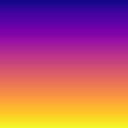
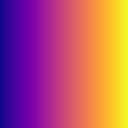

Encoded Values:


,,,,,,,,,,,,,,,

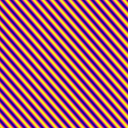
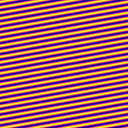
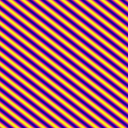
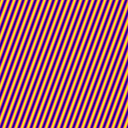
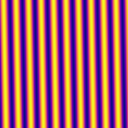
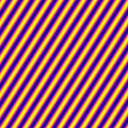
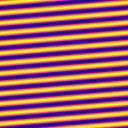
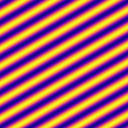
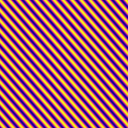
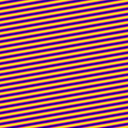
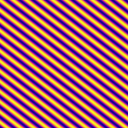
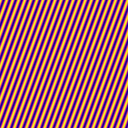
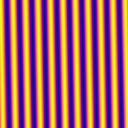
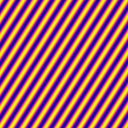
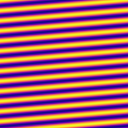
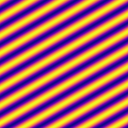

Encoded Integrate Values:
Covariance Magnitude: 0.001


,,,,,,,,,,,,,,,

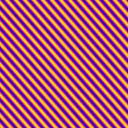
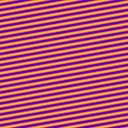
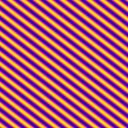
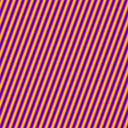
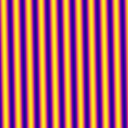
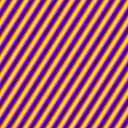
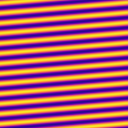
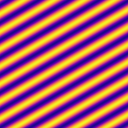
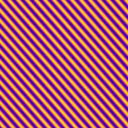
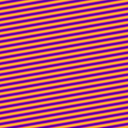
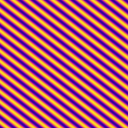
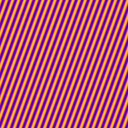
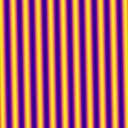
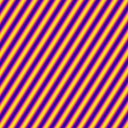
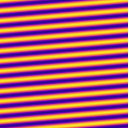
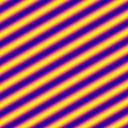

Covariance Magnitude: 0.01


,,,,,,,,,,,,,,,

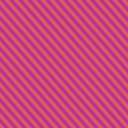
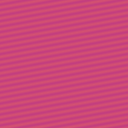
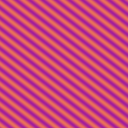
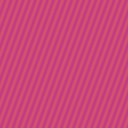
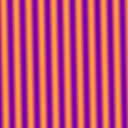
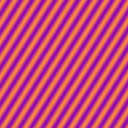
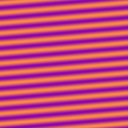
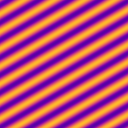
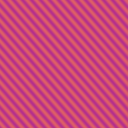
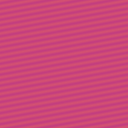
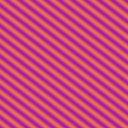
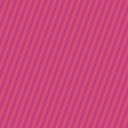
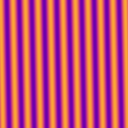
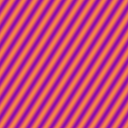
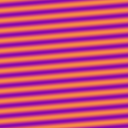
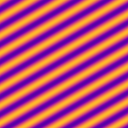

Covariance Magnitude: 0.1


,,,,,,,,,,,,,,,

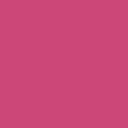
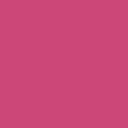
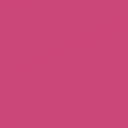
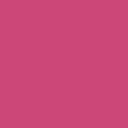
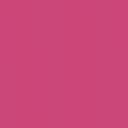
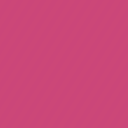
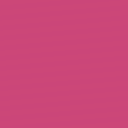
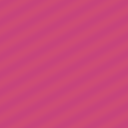
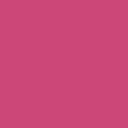
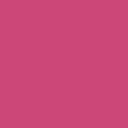
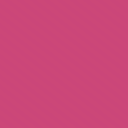
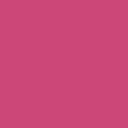
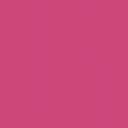
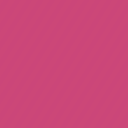
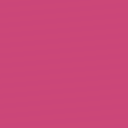
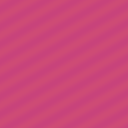

In [25]:
num_frequencies = 8
scale = 10
resolution = 128
covariance_magnitudes = [0.001, 0.01, 0.1]

encoder = encoding.RFFEncoding(in_dim=2, num_frequencies=num_frequencies, scale=scale)

x_samples = torch.linspace(0, 1, resolution)
grid = torch.stack(torch.meshgrid([x_samples, x_samples], indexing="ij"), dim=-1)

encoded_values = encoder(grid)

print("Input Values:")
media.show_images(torch.moveaxis(grid, 2, 0), cmap="plasma", border=True)
print("Encoded Values:")
media.show_images(torch.moveaxis(encoded_values, 2, 0), cmap="plasma", vmin=-1, vmax=1, border=True)

print("Encoded Integrate Values:")
for covariance_magnitude in covariance_magnitudes:
    print(f"Covariance Magnitude: {covariance_magnitude}")
    covs = torch.eye(2)[None, None, :, :] * covariance_magnitude
    encoded_values = encoder(grid, covs=covs)
    media.show_images(torch.moveaxis(encoded_values, 2, 0), cmap="plasma", vmin=-1, vmax=1, border=True)

## Hash Encoding
The hash incoding was originally introduced in Instant-NGP. The encoding is optimized during training. This is a visualization of the initialization.

Input Values:


,,

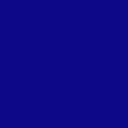
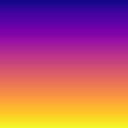
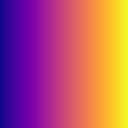

Encoded Values:


,,,,,,,

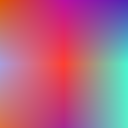
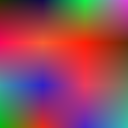
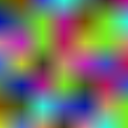
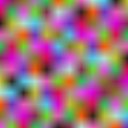
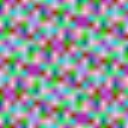
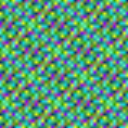
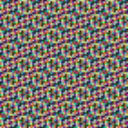
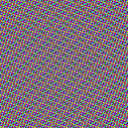

In [4]:
num_levels = 8
min_res = 2
max_res = 128
hash_table_size = 2**4  # Typically much larger tables are used

resolution = 128
slice = 0

# Fixing features_per_level to 3 for easy RGB visualization. Typical value is 2 in networks
features_per_level = 3

encoder = encoding.HashEncoding(
    num_levels=num_levels,
    min_res=min_res,
    max_res=max_res,
    hash_table_size=hash_table_size,
    features_per_level=features_per_level,
    hash_init_scale=0.001,
)

x_samples = torch.linspace(0, 1, resolution)
grid = torch.stack(torch.meshgrid([x_samples, x_samples, x_samples], indexing="ij"), dim=-1)

encoded_values = encoder(grid)

grid_slice = grid[slice, ...]
encoded_values_slice = encoded_values[slice, ...]

print("Input Values:")
media.show_images(torch.moveaxis(grid_slice, 2, 0), cmap="plasma", border=True)

print("Encoded Values:")
encoded_images = encoded_values_slice.view(resolution, resolution, num_levels, 3)
encoded_images = torch.moveaxis(encoded_images, 2, 0)
encoded_images -= torch.min(encoded_images)
encoded_images /= torch.max(encoded_images)
media.show_images(encoded_images.detach().numpy(), cmap="plasma", border=True)

## Spherical Harmonic Encoding
Encode direction using spherical harmoincs. (Mostly used to encode viewing direction)

Level: 1


""

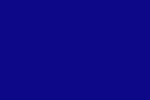

Level: 2


,,

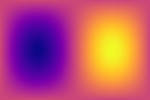
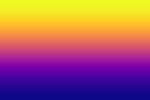
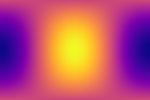

Level: 3


,,,,

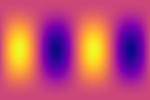
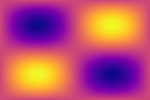
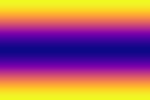
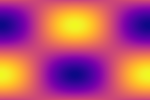
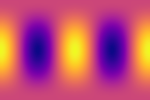

Level: 4


,,,,,,

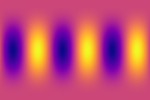
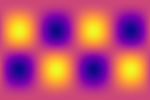
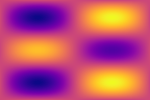
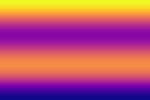
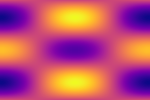
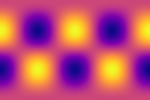
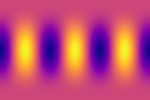

In [5]:
levels = 4

height = 100
width = 150

encoder = encoding.SHEncoding(levels=levels)

theta = torch.linspace(-torch.pi, torch.pi, width)
phi = torch.linspace(0, torch.pi, height)
[theta, phi] = torch.meshgrid([theta, phi], indexing="xy")

directions = torch.stack([torch.cos(theta) * torch.sin(phi), torch.sin(theta) * torch.sin(phi), torch.cos(phi)], dim=-1)

encoded_values = encoder(directions)
encoded_values = torch.moveaxis(encoded_values, 2, 0)

for level in range(levels):
    print(f"Level: {level+1}")
    media.show_images(encoded_values[level**2 : (level + 1) ** 2, ...], cmap="plasma", border=True)